In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

seed = 97
        
import numpy as np
import pandas as pd
# to make this notebook's output stable across runs
np.random.seed(seed)
tf.random.set_seed(seed)

# Common imports
import os
#for dirname, _, filenames in os.walk('/kaggle/input'): #Import from Kaggle
for filename in filenames:
    print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# **Pre-Process Data**

In the following steps we import the data provided by the competition and prepare the Standart Scaler to use in Neural Networks.
We also separate the data into training and validation to check the performance

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/kaggle/input/liverpool-ion-switching/train.csv', low_memory=False)
df.dropna()

scaler = Pipeline([
     ('std_scaler', StandardScaler()),
    ])
df.head()

In [ ]:
corr_matrix = df.corr()
corr_matrix["open_channels"].sort_values(ascending=False)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=97)
for train_index, valid_index in split1.split(df, df['open_channels']):
    strat_train_set = df.loc[train_index]
    strat_valid_set = df.loc[valid_index]
    
X_train, y_train = strat_train_set.drop(['open_channels'],axis=1), strat_train_set['open_channels']
X_valid, y_valid = strat_valid_set.drop(['open_channels'],axis=1), strat_valid_set['open_channels']
y_train.shape

In [ ]:
scale = scaler.fit(X_train)
X_train_scale = scale.transform(X_train)
X_valid_scale = scale.transform(X_valid)
X_train_scale[0:10]

# **Wide and Deep Network **

We developed a simple network but taking the input also as an input of the final layers, this way the netwwork learns both deep patterns and simple rules. It was introduced by Heng-Tze Cheng as a Wide and Deep Neural Network.

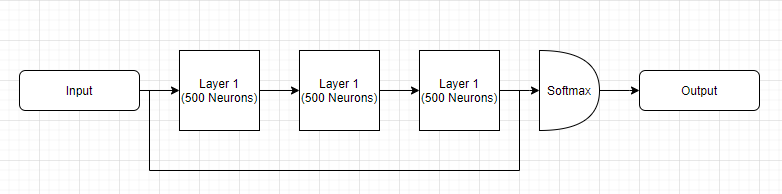

In [ ]:
def create_model:
    from keras import backend as K
    from keras import metrics
    import functools
    from sklearn.multiclass import OneVsOneClassifier

    K.clear_session()

    # scaled = scaler.fit(X_train)
    # X_train = scaled.transform(X_train)
    # X_valid = scaled.transform(X_valid)

    input_A = keras.layers.Input(shape=X_train_scale.shape[1:])
    hidden1 = keras.layers.Dense(500, activation="selu", kernel_initializer="lecun_normal")(input_A)
    hidden2 = keras.layers.Dense(500, activation="selu", kernel_initializer="lecun_normal")(hidden1)
    hidden3 = keras.layers.Dense(500, activation="selu", kernel_initializer="lecun_normal")(hidden2)
    concat = keras.layers.concatenate([input_A, hidden3])
    output = keras.layers.Dense(11, activation="softmax")(concat)

    model = keras.models.Model(inputs=[input_A], outputs=[output])
    return model

In [ ]:
def train_model(model):
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3)

    from sklearn.utils import class_weight
    class_weight_values = class_weight.compute_class_weight('balanced'
                                                   ,np.unique(y_train)
                                                   ,y_train)


    checkpoint_cb = keras.callbacks.ModelCheckpoint("DNN_model.h5", save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    model.compile(loss="sparse_categorical_crossentropy",#sparse_categorical_crossentropy (Classes 1 to 10), binary_crossentropy, huber_loss->continous
                 optimizer="nadam",
                 metrics=['accuracy'])#'sparse_top_k_categorical_accuracy'])#[metrics.mae])#["accuracy"])# ,"categorical_accuracy", sp_precision, sp_recall

    history = model.fit(X_train_scale, y_train, epochs=50,batch_size=16,class_weight=class_weight_values, 
                       validation_data=(X_valid_scale, y_valid), callbacks=[lr_scheduler, checkpoint_cb, early_stopping_cb])

    from sklearn.metrics import f1_score

    Y_pred = model.predict(X_valid_scale).argmax(axis=1)
    score = f1_score(y_valid, Y_pred, average="macro")

    print ('F1 Score: '+str(score))

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def print_score:
    Y_pred = model.predict(X_valid_scale).argmax(axis=1)
    score = f1_score(y_valid, Y_pred, average="macro")

    print ('F1 Score (Neural Network): '+str(score))

In [ ]:
def save_model:
    model.save("NN.h5")

In [ ]:
if os.path.isfile('NN.h5'):
    model = keras.models.load_model('models/NN.h5')
else:
    model = create_model()
    train_model(model)
    print_score()
    save_model()

# **LGBM**

The following commands creates, train and save a LGBM classifier, which is a boost algorithm based on decision trees
(https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

def LGBM_create:
    gb=lgb.LGBMClassifier(
        boosting_type= 'gbdt',
        objective = 'multiclass',
        metric = 'multi_logloss',
        num_class = 11,
        num_leaves = 200,#1000
        bagging_freq = 60, #50
        max_depth = 200, #300
        learning_rate = 0.1,
        feature_fraction = 0.1,
        bagging_fraction = 0.8,
        n_estimators = 150,
        min_data_in_leaf = 500, #1000
        max_bin=5000,
        verbose = 0)
    return gb


In [ ]:
def LGBM_train:
    gb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='multi_logloss',
        early_stopping_rounds=5)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def LGBM_score:
    y_pred = gb.predict(X_valid)
    score = f1_score(y_valid, y_pred, average="macro")
    print ('F1 Score (LGBM): '+str(score))


In [ ]:
def LGBM_save:
    gb.booster_.save_model('LGBM.txt')

In [ ]:
if os.path.isfile('LGBM.txt'):
    gb = keras.models.load_model('LGBM.txt')
else:
    gb = LGBM_create()
    LGBM_train()
    LGBM_score()
    LGBM_save()

# **Stacking**

Next we create a esemble (with a weighted average) of the 2 classifiers.
The weights are calculated through a custom Grid Search, where we look for the combination of parameters that increase F1 Score

Trying creating a Stack with the best algorithms and train it.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

gb = keras.models.load_model('LGBM.txt')

strat_valid_set = strat_valid_set.reset_index(drop=True)

split2 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=100)
for train_index, valid_index in split2.split(strat_valid_set, strat_valid_set['open_channels']):
    strat_valid_train = strat_valid_set.loc[train_index]
    strat_valid_valid = strat_valid_set.loc[valid_index]
    
    
X_t, y_t = strat_valid_train.drop(['open_channels'], axis=1), strat_valid_train['open_channels']
X_v, y_v = strat_valid_valid.drop(['open_channels'],axis=1), strat_valid_valid['open_channels']

X_t_scale = scale.transform(X_t)
X_v_scale = scale.transform(X_v)

#X_pred = np.concatenate(([model.predict(X_t_scale).argmax(axis=1)],[gb.predict(X_t).argmax(axis=1)]), axis=0).transpose()

In [ ]:
from sklearn.metrics import f1_score

def find weights:

    weight_gb = np.empty(len(np.unique(y_t)), dtype=np.float32)
    weight_model = np.empty(len(np.unique(y_t)), dtype=np.float32)

    f1_score_matrix = np.empty((11,11), dtype=np.float32)
    for i in range (len(weight_gb)):
        weight_gb[i] = 0.5
        weight_model[i] = 0.5


    for k in range(11):
        for l in range(11):
            weight_value = k/10
            weight_gb[l] = weight_value
            weight_model[l] = 1-weight_value
            print (str(k) + ' ' + str(l))
            y_p = (gb.predict_proba(X_t)*weight_gb + model.predict(X_t_scale)*weight_model).argmax(axis=1)
            f1_score_matrix[k][l] = f1_score(y_t, y_p, average="macro")
            weight_gb[l] = 0.5
            weight_model[l] = 0.5

    f1_score_matrix
    weight = f1_score_matrix.argmax(axis=0)/10
    return weight

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
#weight = np.array([1. , 1. , 0.7, 0.7, 0.8, 0.9, 0.3, 0.3, 0.6, 0.9, 0.9])
weight = find_weights()
weight_gb = weight
weight_model = 1-weight
y_p = (gb.predict(X_valid)*weight_gb + model.predict(scale.transform(X_valid))*weight_model).argmax(axis=1)
score = f1_score(y_valid, y_p, average="macro")
print ('F1 Score: '+str(score))

See the confusion matrix for the results

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mx = confusion_matrix(y_valid.to_numpy().ravel(), y_pred)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()
#Row = Actual Classes, Column = Predicted Classes

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#Row = Actual Classes, Column = Predicted Classes

# **Test Results**

Last, we use the model to make the predictions on the test data and submit the results